In [1]:
from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import RandomForestRegressor

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore")

%matplotlib inline
pd.options.mode.chained_assignment = None

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

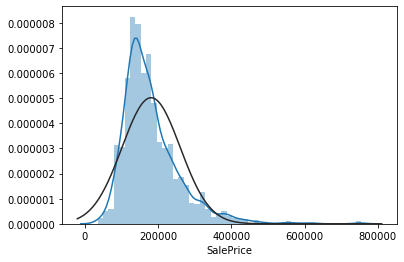

In [3]:
from scipy.stats import norm
sns.distplot(train["SalePrice"], fit = norm)  
# Plot the distribution with a histogram and maximum likelihood gaussian distribution fit

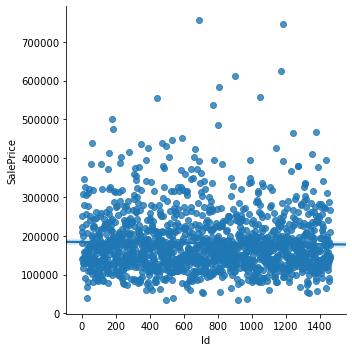

In [4]:
sns.lmplot('Id','SalePrice',data = train)  # x,y scatter

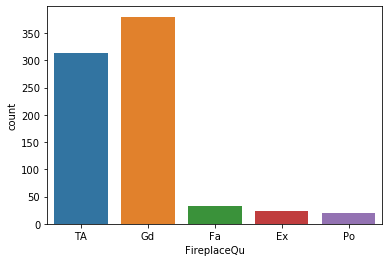

In [5]:
sns.countplot(train['FireplaceQu']) 

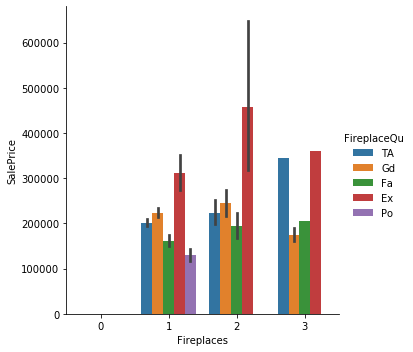

In [6]:
sns.catplot("Fireplaces","SalePrice",data=train, hue = "FireplaceQu", kind = "bar")

In [7]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())  # 非對稱性：0 為對稱，正為右偏，負爲左偏
print("Kurtosis: %f" % train['SalePrice'].kurt())  # 峰度：K>0 高峻峰，K=0 常態峰，K<0 低闊峰

Skewness: 1.882876
Kurtosis: 6.536282


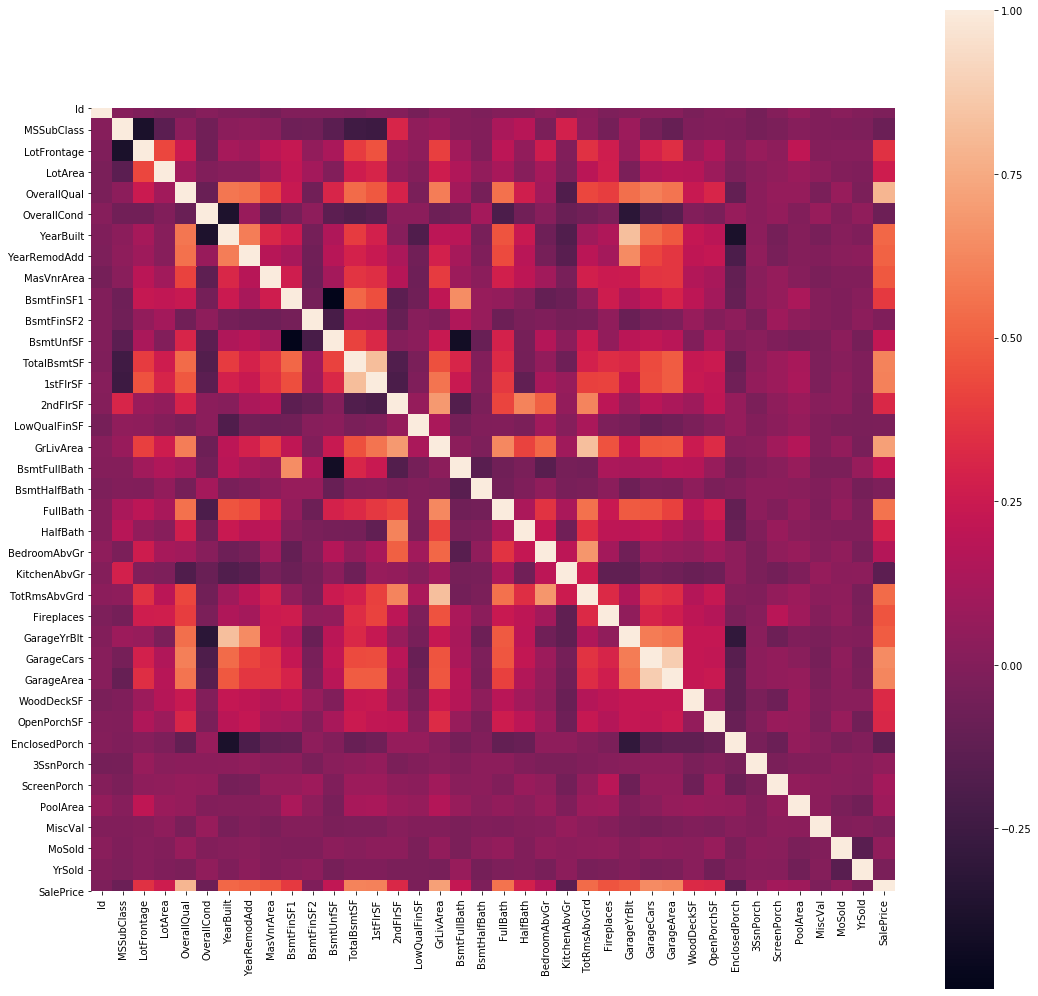

In [8]:
# Obeserve relationship between data and SalePrice  

plt.figure(figsize = (18,18))  
corrmat = train.corr()
sns.heatmap(corrmat, linecolor='black', square = True)  #Correlation matrix (heatmap style)

In [ ]:
plt.figure(figsize = (10, 10))
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True,
                 linecolor='white',
                 fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, 
                 xticklabels=cols.values)
plt.show()

In [ ]:
# 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!

sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show()

In [ ]:
plt.figure(figsize = (12,9))
sns.lineplot(x ='OverallQual', y ='SalePrice', color ='green', data = train)

In [ ]:
# drop useless columns & rows

total = train.isnull().sum().sort_values(ascending = False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

In [ ]:
train = train.drop((missing_data[missing_data['Total'] > 1]).index, axis = 1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing

In [ ]:
train.columns

In [ ]:
#drop outliers

sns.lmplot('GrLivArea','SalePrice',data = train)

In [ ]:
train.describe()

In [ ]:
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)
train = train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index)

In [ ]:
sns.lmplot('LotArea','SalePrice',data = train)

In [ ]:
sns.lmplot('TotalBsmtSF','SalePrice',data = train)

In [ ]:
sns.distplot(train['TotalBsmtSF'], fit = norm)

In [ ]:
sns.distplot(np.log(train[train['TotalBsmtSF']>0]['TotalBsmtSF']), fit=norm)

In [ ]:
hypothesis = train[train['TotalBsmtSF']==0]
sns.distplot(hypothesis['SalePrice'], fit=norm)

In [ ]:
test = test[['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
            'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual',
            'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl',
            'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
            'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
            'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
            'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
            'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
            'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
            'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
            'SaleCondition']]

data = train.append(test, ignore_index = True)
data.set_index('Id',inplace = True)

In [ ]:
(data.isnull().sum()).sort_values(ascending = False).head(18)

In [ ]:
# fill missing data

for col in ('GarageArea', 'GarageCars'):
    data[col] = data[col].fillna(0)#Assuming that theres no Garage by using 0 

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    data[col] = data[col].fillna(0)#Assuming that theres no 
    
data['MSZoning'] = data['MSZoning'].fillna(train['MSZoning'].mode()[0])
data.drop('Utilities', inplace = True, axis = 1)
data['Functional'] = data['Functional'].fillna('Typ')

mode_col = ['Electrical','KitchenQual', 'Exterior1st', 'SaleType']

for col in mode_col:
    data[col] = data[col].fillna(train[col].mode()[0])
    
data["Exterior2nd"] = data["Exterior2nd"].fillna("None")

In [ ]:
data = pd.get_dummies(data)

In [ ]:
data['1stFlrSF'] = data['1stFlrSF'].apply(lambda x : np.log(x))
data['GrLivArea'] = data['GrLivArea'].apply(lambda x : np.log(x))
data['SalePrice'] = data['SalePrice'].apply(lambda x : np.log(x))

In [ ]:
dataTrain = data[pd.notnull(data['SalePrice'])].sort_values(by=["Id"])
dataTest = data[~pd.notnull(data['SalePrice'])].sort_values(by=["Id"])

In [ ]:
yLabels = dataTrain['SalePrice'] 

dropFeatures = ['SalePrice']
dataTrain  = dataTrain.drop(dropFeatures, axis=1)
dataTest  = dataTest.drop(dropFeatures, axis=1)

In [ ]:
from sklearn.linear_model import Ridge

clf_R = Ridge(alpha = .001)
#Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
#normalize=False, random_state=None, solver='auto', tol=0.001)
clf_R.fit(dataTrain, yLabels)
pre_Ridge = clf_R.predict(dataTest)
clf_R.score(dataTrain, yLabels)

In [ ]:
rfModel = RandomForestRegressor(n_estimators = 1200,
                                max_depth = 15,
                                min_samples_split = 20,
                                min_samples_leaf = 10,
                                oob_score = True,
                                random_state = 42,
                                n_jobs = -1) 

rfModel.fit(dataTrain, yLabels)
pre_RF = rfModel.predict(X = dataTest)
rfModel.score(dataTrain, yLabels)


In [ ]:
import lightgbm as lgb

LGB = lgb.LGBMRegressor(objective='regression',
                              num_leaves=5,
                              learning_rate=0.05, 
                              n_estimators=720,
                              max_bin = 55, 
                              bagging_fraction = 0.8,
                              bagging_freq = 5, 
                              feature_fraction = 0.2319,
                              feature_fraction_seed=9, 
                              bagging_seed=9,
                              min_data_in_leaf =6, 
                              min_sum_hessian_in_leaf = 11)

LGB.fit(dataTrain, yLabels)
pre_LGB = LGB.predict(X = dataTest)
LGB.score(dataTrain, yLabels)

In [ ]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [test],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#This parameter defines the number of HP points to be tested
n_HP_points_to_test = 100

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMRegressor(max_depth=-1, random_state=42, n_jobs=-1, n_estimators=720)
gs = RandomizedSearchCV(estimator=clf, param_distributions=param_test, 
                        n_iter=n_HP_points_to_test,
                        scoring='roc_auc',
                        cv=3,
                        refit=True,
                        random_state=314,
                        verbose=True)

train=dataTrain, yLabels         
gs.fit(*train, **fit_params)

In [ ]:
import xgboost as xgb

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, 
                             gamma=0.0468, 
                             learning_rate=0.05, 
                             max_depth=3, 
                             min_child_weight=1.7817, 
                             n_estimators=2200,
                             reg_alpha=0.4640, 
                             reg_lambda=0.8571,
                             subsample=0.5213, 
                             silent=1,
                             random_state =42, 
                             nthread = -1)

model_xgb.fit(dataTrain, yLabels)
pre_xgb = model_xgb.predict(dataTest)
model_xgb.score(dataTrain, yLabels)

In [ ]:
# Package for stacking models
from vecstack import stacking

models = [clf_R, rfModel, LGB, model_xgb]
S_train, S_test = stacking(models,
                           dataTrain, yLabels, dataTest,
                           regression = True,
                           mode = 'oof_pred_bag',
                           n_folds = 5,
                           random_state = 42,
                           verbose = 2)

In [ ]:
from sklearn.linear_model import Lasso

clf_L = Lasso(alpha = .001)
clf_L.fit(S_train, yLabels)
pre_Lasso = clf_L.predict(S_test)
clf_L.score(S_train, yLabels)

In [ ]:
submit = pd.read_csv('sample_submission.csv')
submit['SalePrice'] = pre_Lasso 
submit['SalePrice'] = submit['SalePrice'].apply(lambda x : np.exp(x))
submit.to_csv('submit.csv', index = False)
submit.head()

In [ ]:
from sklearn.ensemble import IsolationForest

ilf = IsolationForest(random_state = 42,
                      n_jobs = -1,
                      verbose=2) 

ilf.fit(dataTrain, yLabels)
pre_ilf = ilf.predict(X = dataTrain)

dict1 = {'Id': dataTrain.index, 
        'pre_ilf' : pre_ilf}

dict1 = pd.DataFrame.from_dict(dict1)
sns.distplot(dict1['pre_ilf'], fit=norm)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(loss = 'quantile',
                                alpha = 0.5,
                                n_estimators = 1200,
                                max_depth = 15,
                                learning_rate = .1,
                                min_samples_leaf = 10,
                                min_samples_split = 20)
GBR.fit(dataTrain, yLabels)
pre_GBR = GBR.predict(X = dataTest)
GBR.score(dataTrain, yLabels)

In [ ]:
from sklearn.linear_model import Lasso

clf_L = Lasso(alpha = .001)
clf_L.fit(dataTrain, yLabels)
pre_Lasso = clf_L.predict(dataTest)
clf_L.score(dataTrain, yLabels)